## `Berchmans Kevin S`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
import gc
import time
import itertools
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score

In [2]:
train_file = 'train.gz'
test_file = 'test.gz'

reader = pd.read_csv(train_file, chunksize=10**6, iterator=True) 
test = pd.read_csv(test_file, compression='gzip')

train = pd.DataFrame()
start = time.time()  

for i, chunk in enumerate(reader): 
    chunk = chunk.sample(frac=.65, replace=False, random_state=516)
    neg_samp = chunk[chunk['click'] == 0].sample(n=len(chunk[chunk['click'] == 1]), random_state=2021)
    train = pd.concat([train, neg_samp, chunk[chunk['click'] == 1]], axis=0)  
    if i % 20 == 0:
        print('Processing Chunk No. {}'.format(i))

print('the program costs %.2f seconds'%(time.time() - start))

del neg_samp
gc.collect()

print('train has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
train['click'].value_counts()

Processing Chunk No. 0
Processing Chunk No. 20
Processing Chunk No. 40
the program costs 236.82 seconds
train has 8925858 rows and 24 columns
test has 4577464 rows and 23 columns


1    4462929
0    4462929
Name: click, dtype: int64

In [3]:
# train.iloc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]] 

ls = list(test.columns)
#ls.remove('click')
for i in ls:
    train_len = len(train[i].astype(str).value_counts())
    test_len = len(test[i].astype(str).value_counts())
    print(i, 'train: {} test：{}'.format(train_len, test_len))

id train: 8925858 test：4577464
hour train: 240 test：24
C1 train: 7 test：7
banner_pos train: 7 test：6
site_id train: 3870 test：2825
site_domain train: 5251 test：3366
site_category train: 25 test：22
app_id train: 6135 test：3952
app_domain train: 379 test：201
app_category train: 29 test：28
device_id train: 931588 test：291759
device_ip train: 2893925 test：1077199
device_model train: 7012 test：5438
device_type train: 5 test：4
device_conn_type train: 4 test：4
C14 train: 2519 test：1257
C15 train: 8 test：8
C16 train: 9 test：9
C17 train: 434 test：240
C18 train: 4 test：4
C19 train: 67 test：47
C20 train: 169 test：162
C21 train: 60 test：39


In [4]:
y_train = train[['click']]
x_train = train.drop(['click','id'], axis=1)
x_test = test.drop(['id'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=256)
del train
gc.collect()

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7140686 entries, 6816441 to 16294521
Data columns (total 22 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hour              int64 
 1   C1                int64 
 2   banner_pos        int64 
 3   site_id           object
 4   site_domain       object
 5   site_category     object
 6   app_id            object
 7   app_domain        object
 8   app_category      object
 9   device_id         object
 10  device_ip         object
 11  device_model      object
 12  device_type       int64 
 13  device_conn_type  int64 
 14  C14               int64 
 15  C15               int64 
 16  C16               int64 
 17  C17               int64 
 18  C18               int64 
 19  C19               int64 
 20  C20               int64 
 21  C21               int64 
dtypes: int64(13), object(9)
memory usage: 1.2+ GB


In [5]:
model = CatBoostClassifier(iterations=25,learning_rate=0.9,task_type='GPU',loss_function='Logloss', 
                           gpu_ram_part=0.9, boosting_type='Plain', max_ctr_complexity=2, 
                           depth=6, gpu_cat_features_storage='CpuPinnedMemory')

cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

model.fit(x_train, y_train, eval_set=(x_val, y_val), cat_features=cat_features,verbose=10)

0:	learn: 0.6526267	test: 0.6347312	best: 0.6347312 (0)	total: 714ms	remaining: 17.1s
10:	learn: 0.5838453	test: 0.5739056	best: 0.5739056 (10)	total: 6.3s	remaining: 8.02s
20:	learn: 0.5772199	test: 0.5669305	best: 0.5669305 (20)	total: 11.8s	remaining: 2.25s
24:	learn: 0.5760042	test: 0.5655205	best: 0.5655205 (24)	total: 13.9s	remaining: 0us
bestTest = 0.5655205423
bestIteration = 24


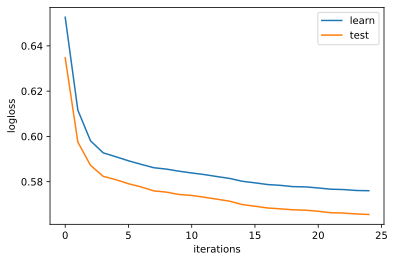

In [6]:
def plot_catboost(y_label):
    '''plot catboost learning curve
    '''
    learn_error = pd.read_csv('./catboost_info/learn_error.tsv', sep='\t')
    test_error = pd.read_csv('./catboost_info/test_error.tsv', sep='\t')
    metric = pd.concat([learn_error, test_error.iloc[:,1]], axis=1)
    metric.columns = ['iterations','learn','test']
    plt.rcParams['figure.facecolor'] = 'white'
    metric.plot(x='iterations',y=['learn','test'])
    plt.ylabel(y_label)
    plt.show()

plot_catboost('logloss')

In [7]:
#del x_train, y_train
gc.collect()

3369

In [8]:
y_test = model.predict(x_test, 
                       prediction_type='Probability', 
                       ntree_end=model.get_best_iteration(), 
                       thread_count=-1,
                       verbose=None)
gc.collect()
y_val_pred = model.predict(x_val, 
                       prediction_type='Probability', 
                       ntree_start=0,
                       ntree_end=model.get_best_iteration(), 
                       thread_count=-1,
                       verbose=None)

In [9]:
#y_val_pred = model.predict_proba(x_val)[:,1]
y_val_class = np.where(y_val_pred[:, 1] > 0.5,1,0)
print('Out of folds logloss is {:.4f}'.format(log_loss(y_val, y_val_pred[:, 1])))
print('Out of folds roc_auc_score is {:.4f}'.format(roc_auc_score(y_val, y_val_pred[:, 1])))

Out of folds logloss is 0.5657
Out of folds roc_auc_score is 0.7727


In [10]:
#del x_val
gc.collect()

40

In [11]:
# submission_df["click"] = 
submission = pd.read_csv('../input/avazu-ctr-prediction/sampleSubmission.gz', compression='gzip')
submission = pd.DataFrame({'id': submission['id'], 'click': y_test[:, 1]})
submission.to_csv('submission.csv',index = False)
submission.head()

,id,click
0,10000174058809263569,0.135338
1,10000182526920855428,0.568023
2,10000554139829213984,0.641001
3,10001094637809798845,0.090093
4,10001377041558670745,0.665370


In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    '''This function prints and plots the confusion matrix.
       Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.64483422 0.35516578]
 [0.23635818 0.76364182]]


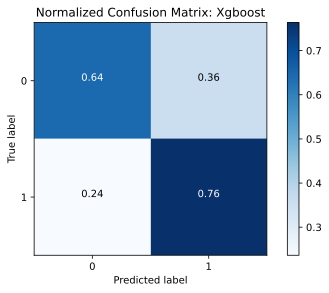

In [13]:
plt.rcParams['figure.facecolor'] = 'white'
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_val, y_val_class),
                      classes=class_names, 
                      normalize=True, 
                      title='Normalized Confusion Matrix: Xgboost')